In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from ae import VariationalAutoencoder
import matplotlib.pyplot as plt
from utils import display_examples, display_latents

## KL Divergence Loss

In [2]:
def calculate_kl_loss(mean, log_variance):
    kl_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp(), dim=1).mean()
    return kl_loss

## Downloading the MNIST dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor and scale to [0, 1]
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Load test set
    download=True,
    transform=transform
)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the download by printing some info
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60000
Test set size: 10000


## Declarations

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 32, 64, 64, 64)
convKernels =   (3, 3, 2, 2)
convStrides =   (1, 1, 2, 2)
convPadding =   (1, 1, 0, 0)

# AutoEncoder
vae = VariationalAutoencoder(2, train_dataset[0][0].shape, convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

## Main Training Loop

In [6]:
alpha = 0.0008
iterations = []
max_epochs = 10

vae.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = vae(images)
        
        loss = mse_loss(outputs, images) + alpha * calculate_kl_loss(vae.mu, vae.log_variance)
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Loss: {loss.detach()}")

torch.save(vae.state_dict(), './models/vae.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Loss: 0.4103148579597473
Epoch: 1, Loss: 0.04850136488676071
Epoch: 2, Loss: 0.054249897599220276
Epoch: 3, Loss: 0.05072084441781044
Epoch: 4, Loss: 0.05241360887885094
Epoch: 5, Loss: 0.04400385916233063
Epoch: 6, Loss: 0.04568759351968765
Epoch: 7, Loss: 0.04789401963353157
Epoch: 8, Loss: 0.046930402517318726
Epoch: 9, Loss: 0.04602181538939476
Final Loss: 0.05651460587978363


## Displaying Examples

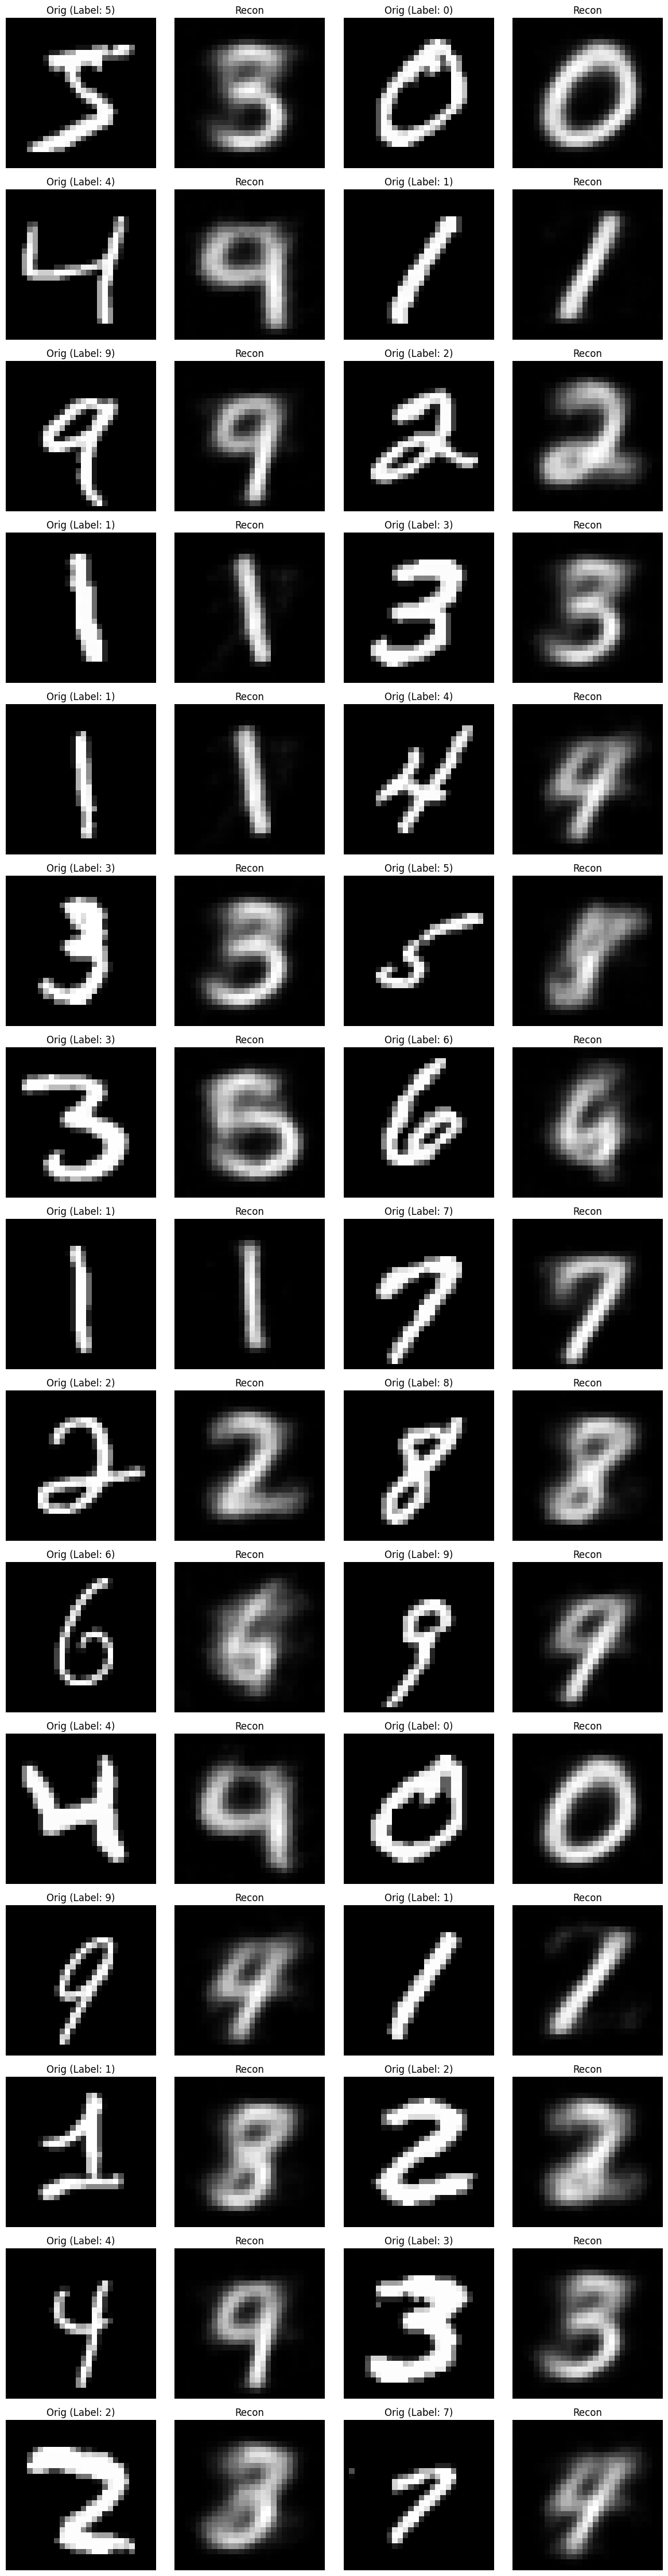

In [7]:
vae = VariationalAutoencoder(2, train_dataset[0][0].shape, convChannels, convKernels, convStrides, convPadding).to(device)
vae.load_state_dict(torch.load('models/vae.pth', weights_only=True))
display_examples(vae, train_dataset, device)

## Visualizing Latent Space

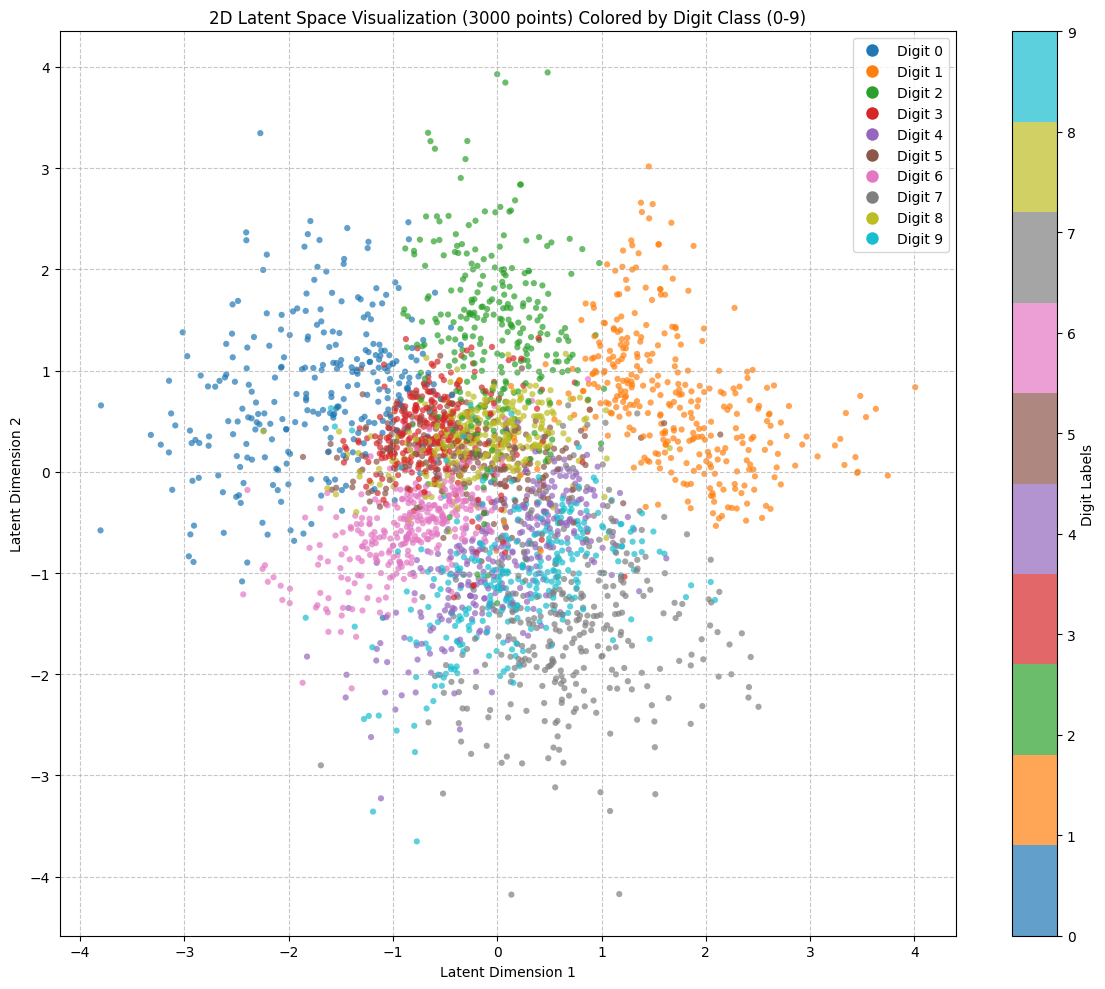

In [8]:
display_latents(vae, train_loader, device)

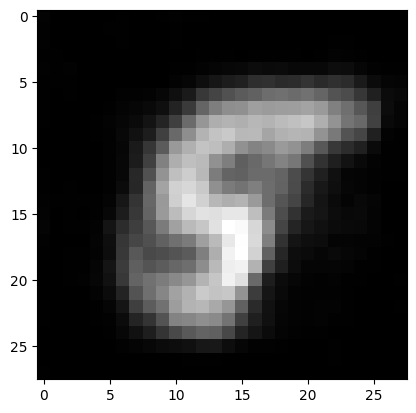

In [9]:
vae.eval()
with torch.no_grad():
    random = vae.sample_random()

    plt.imshow(random.cpu().permute(1, 2, 0), cmap="gray")